In [2]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display
from matplotlib import pyplot as plt
import seaborn as sns

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
df = pd.read_csv('./data.csv')

# Encode player and map IDs as categorical integers starting from 0 for PyMC3
df['player_idx'] = df['player_id'].astype('category').cat.codes
df['map_idx'] = df['map_id'].astype('category').cat.codes

# Number of players and maps
J = df['player_idx'].nunique()
M = df['map_idx'].nunique()

print(J, M)

# Initialize scalers
scaler_pp = StandardScaler()
scaler_jump = StandardScaler()
scaler_diff = StandardScaler()

# scaler_pp = MinMaxScaler()
# scaler_jump = MinMaxScaler()
# scaler_diff = MinMaxScaler()

# Fit and transform
df['pp_scaled'] = scaler_pp.fit_transform(df[['player_pp']])
df['jump_scaled'] = scaler_jump.fit_transform(df[['jump_distance']])
df['diff_scaled'] = scaler_diff.fit_transform(df[['map_sr']])

display(df)

print(f'error_stdev: {np.std(df['error_distance'])}')

print(df[['pp_scaled', 'jump_scaled', 'diff_scaled']].describe())

15 4


,Unnamed: 0,player_id,player_pp,map_sr,map_id,error_distance,jump_distance,player_idx,map_idx,pp_scaled,jump_scaled,diff_scaled
0,0,-Axolotl,11672,7.14,BLOODY_RED,8.806576,0.000000,0,0,1.278346,-1.518983,2.746081
1,1,-Axolotl,11672,7.14,BLOODY_RED,11.663009,113.486139,0,0,1.278346,-0.473212,2.746081
2,2,-Axolotl,11672,7.14,BLOODY_RED,18.494863,224.025104,0,0,1.278346,0.545401,2.746081
3,3,-Axolotl,11672,7.14,BLOODY_RED,19.419328,113.229855,0,0,1.278346,-0.475573,2.746081
4,4,-Axolotl,11672,7.14,BLOODY_RED,12.454352,295.908770,0,0,1.278346,1.207806,2.746081
...,...,...,...,...,...,...,...,...,...,...,...,...
4010,201,YukiTanuki,9210,6.54,gmtn,25.777796,85.603738,7,3,0.363052,-0.730147,0.064213
4011,202,YukiTanuki,9210,6.54,gmtn,22.050718,46.690470,7,3,0.363052,-1.088732,0.064213
4012,203,YukiTanuki,9210,6.54,gmtn,9.405128,47.010637,7,3,0.363052,-1.085781,0.064213
4013,204,YukiTanuki,9210,6.54,gmtn,25.582549,60.638272,7,3,0.363052,-0.960203,0.064213


error_stdev: 8.696050162175824
          pp_scaled   jump_scaled   diff_scaled
count  4.015000e+03  4.015000e+03  4.015000e+03
mean   1.698932e-16 -2.619186e-16 -6.077220e-15
std    1.000125e+00  1.000125e+00  1.000125e+00
min   -8.712210e-01 -1.518983e+00 -4.092681e+00
25%   -8.712210e-01 -1.002205e+00  6.421341e-02
50%   -1.473870e-01  8.479196e-02  6.421341e-02
75%    7.136296e-01  7.946343e-01  6.421341e-02
max    2.544591e+00  3.004129e+00  2.746081e+00


In [4]:
player_idx = df['player_idx'].values
map_idx = df['map_idx'].values
y = df['error_distance'].values
y_safe = y + 1e-5 # 0 hit error can mess up some models, added small positive value to fix this
pp_scaled = df['pp_scaled'].values
jump_scaled = df['jump_scaled'].values
diff_scaled = df['diff_scaled'].values

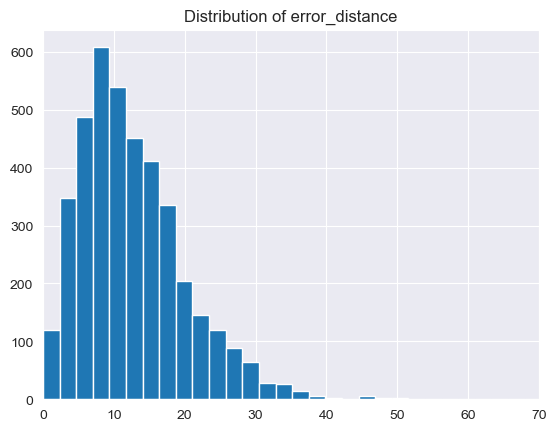

In [5]:
plt.hist(df['error_distance'], bins=100)
plt.title("Distribution of error_distance")
plt.xlim(0, 70)
plt.show()

In [6]:
# old model
with pm.Model() as hierarchical:
    # non-informative priors for coefficients
    beta0 = pm.Normal('beta0', mu=0, sigma=1000)
    beta1 = pm.Normal('beta1', mu=200, sigma=1000)
    beta2 = pm.Normal('beta2', mu=0, sigma=1000)
    beta3 = pm.Normal('beta3', mu=200, sigma=1000)
    
    # priors for player and map deviations
    tau = pm.HalfCauchy('tau', beta=2.5)
    phi = pm.HalfCauchy('phi', beta=2.5)
    
    # player intercept
    epsilon = pm.Normal('epsilon', mu=0, sigma=tau, shape=J)
    
    # map intercept
    gamma = pm.Normal('gamma', mu=0, sigma=phi, shape=M)
    
    # player sigma
    alpha = pm.Gamma('alpha', alpha=2, beta=0.1)
    beta_param = pm.Gamma('beta_param', alpha=2, beta=0.1)
    sigma = pm.InverseGamma('sigma', alpha=alpha, beta=beta_param, shape=J)
    
    # expected value
    mu = (
            beta0 
          + beta1 * pp_scaled 
          + beta2 * jump_scaled 
          + beta3 * diff_scaled 
          + epsilon[player_idx] 
          + gamma[map_idx]
         )
    
    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma[player_idx], observed=y)

In [7]:
# hierarchical model without map difficulty
with pm.Model() as hierarchical_nodiff:
    # priors for beta coefficients
    beta0 = pm.Normal('beta0', mu=0, sigma=10)
    beta1 = pm.Normal('beta1', mu=200, sigma=10)
    beta2 = pm.Normal('beta2', mu=0, sigma=.5)
    
    # priors for player and map deviations
    tau = pm.HalfCauchy('tau', beta=2.5)
    phi = pm.HalfCauchy('phi', beta=2.5)
    
    # player intercept 
    epsilon = pm.Normal('epsilon', mu=0, sigma=tau, shape=J)
    
    # player sigma
    alpha = pm.Gamma('alpha', alpha=2, beta=0.1)
    beta_param = pm.Gamma('beta_param', alpha=2, beta=0.1)
    sigma = pm.InverseGamma('sigma', alpha=alpha, beta=beta_param, shape=J)
    
    # ev
    mu = (
            beta0 
          + beta1 * pp_scaled 
          + beta2 * jump_scaled 
          + epsilon[player_idx] 
         )
    
    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma[player_idx], observed=y)

In [8]:
# attempting the model with a more accurate gamma distribution
with pm.Model() as hierarchical_nodiff_gamma:
    # priors for alpha coefficients
    alpha0 = pm.Normal('alpha0', mu=0, sigma=.5, initval=1.)
    alpha1 = pm.Normal('alpha1', mu=0, sigma=.5, initval=1.)
    alpha2 = pm.Normal('alpha2', mu=0, sigma=.5, initval=1.)
    
    # prior for tau
    tau = pm.HalfNormal('tau', sigma=1)
    
    # player stdevs
    epsilon_raw = pm.Normal('epsilon_raw', mu=0, sigma=1, shape=J)
    epsilon = pm.Deterministic('epsilon', epsilon_raw * tau)

    # log-gamma parameters
    log_alpha_j = (
        alpha0 + 
        alpha1 * pp_scaled + 
        alpha2 * jump_scaled + 
        epsilon[player_idx]
    )
    
    alpha_j = pm.Deterministic('alpha_j', pm.math.exp(log_alpha_j))

    # rate parameter
    beta = pm.Gamma('beta', alpha=2, beta=0.1)
    
    # likelihood
    y_obs = pm.Gamma('y_obs', alpha=alpha_j, beta=beta, observed=y_safe)

In [9]:
hierarchical_nodiff_gamma.debug()

point={'alpha0': array(1.), 'alpha1': array(1.), 'alpha2': array(1.), 'tau_log__': array(0.), 'epsilon_raw': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'beta_log__': array(2.99573227)}

No problems found


In [10]:
with hierarchical_nodiff_gamma:    
    trace_extended = pm.sample(
        draws=2000, 
        tune=1000, 
        target_accept=0.9, 
        return_inferencedata=True,
        cores=16, # tweak for your own system
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [alpha0, alpha1, alpha2, tau, epsilon_raw, beta]


Output()

Sampling 16 chains for 1_000 tune and 2_000 draw iterations (16_000 + 32_000 draws total) took 170 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.


                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha0           1.055  0.038   0.985    1.126      0.000    0.000    9493.0   
alpha1          -0.066  0.034  -0.133   -0.004      0.000    0.000   11908.0   
alpha2           0.076  0.009   0.060    0.094      0.000    0.000   30262.0   
tau              0.102  0.029   0.055    0.154      0.000    0.000    8301.0   
epsilon_raw[0]  -0.118  0.498  -1.080    0.802      0.004    0.003   17880.0   
epsilon_raw[1]  -1.387  0.586  -2.493   -0.287      0.006    0.004   10694.0   
epsilon_raw[2]   0.517  0.582  -0.607    1.596      0.004    0.003   24075.0   
epsilon_raw[3]  -0.055  0.499  -0.987    0.895      0.004    0.003   15840.0   
epsilon_raw[4]  -0.874  0.489  -1.790    0.058      0.004    0.003   16146.0   
epsilon_raw[5]   0.526  0.464  -0.348    1.396      0.004    0.003   15189.0   
epsilon_raw[6]  -0.686  0.464  -1.560    0.181      0.003    0.003   18563.0   
epsilon_raw[7]  -0.934  0.480  -1.876   

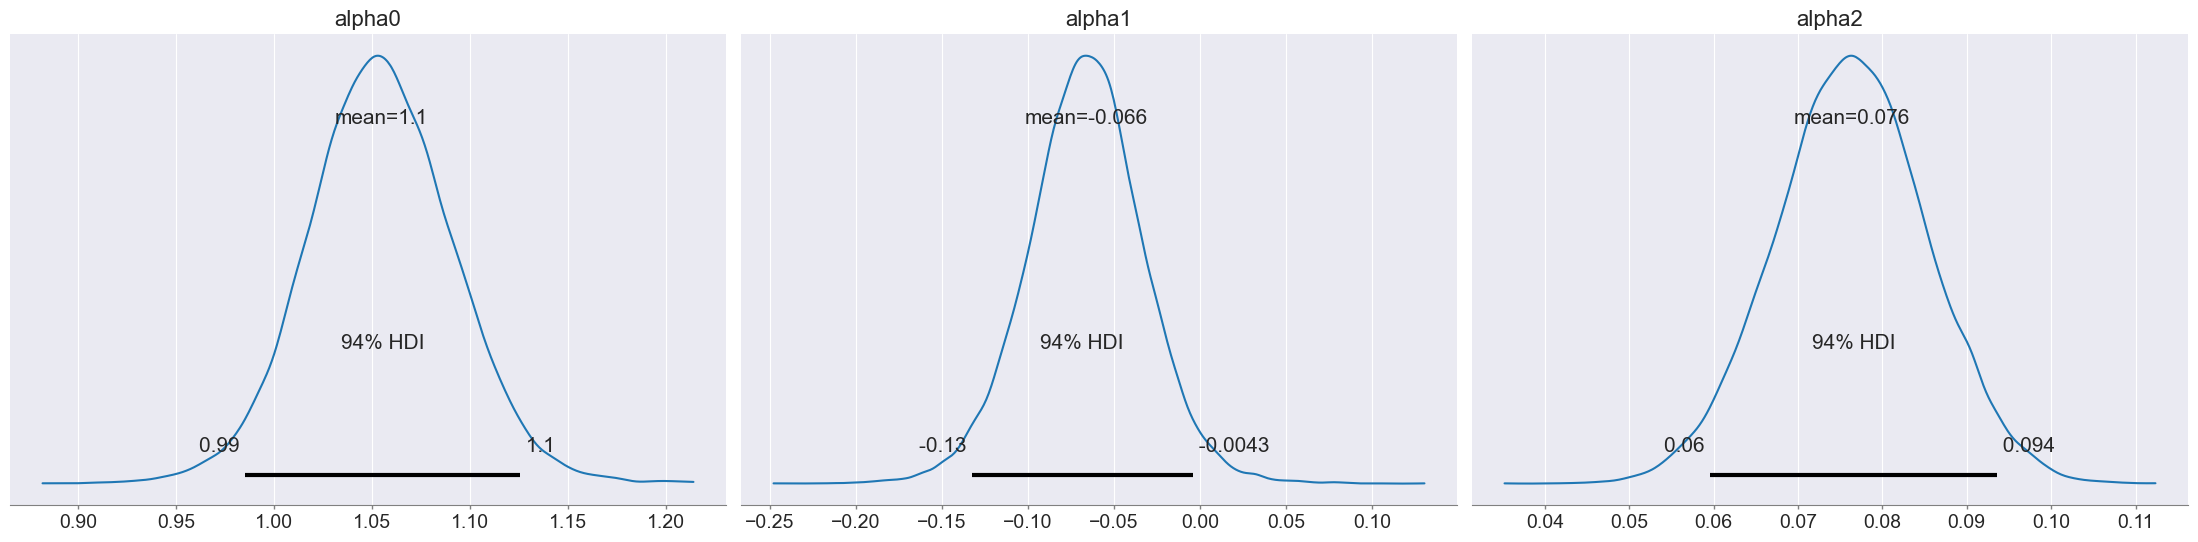

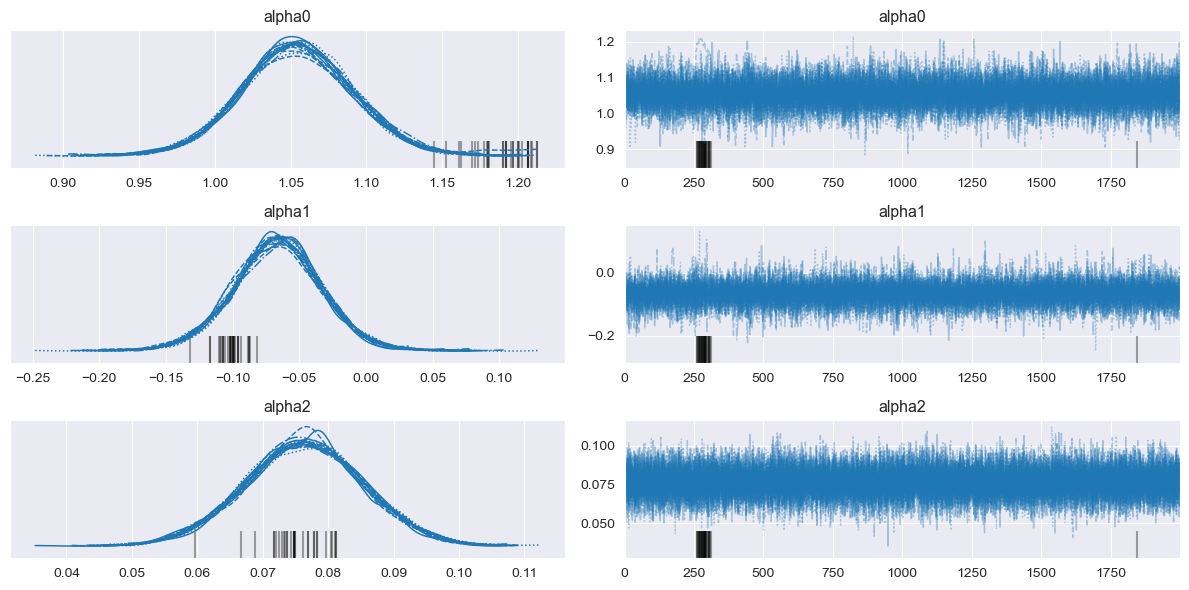

In [11]:
print(az.summary(trace_extended, var_names=[
    'alpha0', 'alpha1', 'alpha2',
    'tau', 'epsilon_raw', 'beta'
]))

axes = az.plot_posterior(trace_extended, var_names=['alpha0', 'alpha1', 'alpha2'])
fig = plt.gcf()
fig.tight_layout()
plt.savefig('./alpha_posteriors.png')
plt.show()

axes = az.plot_trace(trace_extended, var_names=['alpha0', 'alpha1', 'alpha2'])
fig = plt.gcf()
fig.tight_layout()
plt.savefig('./alpha_trace.png')
plt.show()

In [12]:
with hierarchical_nodiff_gamma:
    # Sample from the posterior predictive using the existing data:
    ppc = pm.sample_posterior_predictive(
        trace_extended, 
        var_names=['y_obs']
    )

Sampling: [y_obs]


Output()

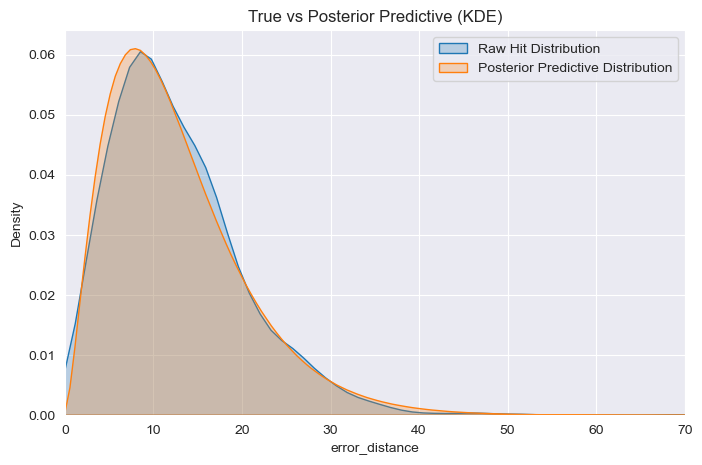

<Figure size 640x480 with 0 Axes>

In [13]:
true_vals = df["error_distance"]

y_ppc = ppc.posterior_predictive["y_obs"].values.reshape(-1)

plt.figure(figsize=(8, 5))

sns.kdeplot(true_vals, label='Raw Hit Distribution', fill=True)
sns.kdeplot(y_ppc, label='Posterior Predictive Distribution', fill=True)

plt.title("True vs Posterior Predictive (KDE)")
plt.xlim(0, 70)
plt.legend()
plt.show()
plt.savefig('true_vs_PPD.png')

In [ ]:
%%sql
